In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import einops
from typing import List, Tuple
from torch import Tensor

import torch
import torch.nn as nn

# Transformers

In the previous notebook we explored the high-level structure of a transformer. To reiterate:

1. Words are tokenized, or converted into sub-units of language.
2. Tokens are passed to an embedding matrix $W_E$ which is basically a lookup table mapping tokens to vectors.
3. The embedding is passed through a series of transformer blocks which additively update a hidden state. By adding onto rather than directly transforming the hidden state, we maintain residual connections between early and late layers of the transformer.
4. The updated embedding is multiplied by an unembed matrix $W_U$ that projects the hidden state back into vocabulary space.
5. We repeat these steps autoregressively, generating tokens one at a time and appending them to a running sequence.

In this notebook, we'll build a transformer from scratch to understand the function of each component.

## Attention

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-attn-30.png" width="1200">

Attention layers play a crucial role in transformer architectures, enabling tokens to access information from distant positions in the sequence. Here, we will be using a _scaled dot product attention_. As the name suggests, we will compute our attention scores by computing dot products.

This attention function takes in three inputs: the _queries_ $Q$, the _keys_ $K$, and the _values_ $V$. The names are not completely arbitrary here: we can think of the keys and values as key-value pairs in a Python dictionary.

For a given sequence, $Q$, $K$, and $V$ will each be a $(seq, d_{head})$ matrix where $seq$ is the length of the token sequence.

For instance, the queries will be represented by the matrix

\begin{align}
&\:\begin{matrix}\xleftarrow{\hspace{0.5em}} & d_k & \xrightarrow{\hspace{0.5em}}\end{matrix} \\
Q =\;\, &\begin{bmatrix}\leftarrow & \vec{q}_1 & \rightarrow \\ \leftarrow & \vec{q}_2 & \rightarrow \\ & \vdots & \\ \leftarrow & \vec{q}_t & \rightarrow\end{bmatrix}\;\;\begin{matrix}\Big\uparrow \\ t \\ \Big\downarrow\end{matrix}
\end{align}

We will compute attention scores from $Q$ and $K$. In particular, we will matrix multiply $Q$ and the transpose of $K$ to calculate the dot product between each query vector and each key vector

This gives us a $(seq_{q}, seq_{k})$ matrix $E$, where the $(i, j)^\text{th}$ element in $E$ is the attention score between the $i^\text{th}$ query vector and the $j^\text{th}$ key vector. We’ll call $E$ the attention scores matrix.

\begin{align}
&\begin{bmatrix}
    \;\;\; \uparrow \;\; & \quad \uparrow \; & & \;\, \uparrow \\ 
    \;\;\; \vec{k}_1 \;\; & \quad \vec{k}_2 \; & \;\; \cdots & \;\;\;\, \vec{k}_T \;\; \\ 
    \;\;\; \downarrow \;\; & \quad \downarrow \; & & \;\, \downarrow
\end{bmatrix} \\
E = QK^\intercal =
\begin{bmatrix}
    \leftarrow & \vec{q}_1 & \rightarrow \vphantom{\vec{q}_1\cdot\vec{k}_t} \\
    \leftarrow & \vec{q}_2 & \rightarrow \vphantom{\vec{q}_2\cdot\vec{k}_t} \\
    & \vdots & \\
    \leftarrow & \vec{q}_t & \rightarrow \vphantom{\vec{q}_T\cdot\vec{k}_t}
\end{bmatrix}
&\begin{bmatrix}
    \vec{q}_1\cdot\vec{k}_1 & \vec{q}_1\cdot\vec{k}_2 & \cdots & \vec{q}_1\cdot\vec{k}_T \\
    \vec{q}_2\cdot\vec{k}_1 & \vec{q}_2\cdot\vec{k}_2 & \cdots & \vec{q}_2\cdot\vec{k}_T \\
    \vdots & \vdots & \ddots & \vdots \\
    \vec{q}_t\cdot\vec{k}_1 & \vec{q}_t\cdot\vec{k}_2 & \cdots & \vec{q}_t\cdot\vec{k}_T \\
\end{bmatrix}=
\begin{bmatrix}
    e_{1,1} & e_{1,2} & \cdots & e_{1,T} \vphantom{\vec{q}_1\cdot\vec{k}_T} \\
    e_{2,1} & e_{2,2} & \cdots & e_{2,T} \vphantom{\vec{q}_2\cdot\vec{k}_T} \\
    \vdots & \vdots & \ddots & \vdots \\
    e_{t,1} & e_{t,2} & \cdots & e_{t,T} \vphantom{\vec{q}_T\cdot\vec{k}_T} \\
\end{bmatrix}
\end{align}


Next, we will _scale_ each of the attention scores by a factor of $\frac{1}{\sqrt{d_k}}$. This is done to push the dot products into a reasonable range for the subsequent softmax - too negative of a dot product will results in a near-zero gradient and thus the model will train less effectively.

\begin{equation}
E' = \frac{1}{\sqrt{d_k}}E
\end{equation}


Finally we take the softmax of $E'$ to get our attention weights, where the sum in softmax is done over the columns of $E'$

\begin{equation}
\alpha = \operatorname{softmax}(E') =
\begin{bmatrix}
    \operatorname{softmax}\begin{pmatrix}e'_{1,1} & e'_{1,2} & \cdots & e'_{1,T}\end{pmatrix} \\
    \operatorname{softmax}\begin{pmatrix}e'_{2,1} & e'_{2,2} & \cdots & e'_{2,T}\end{pmatrix} \\
    \vdots \\
    \operatorname{softmax}\begin{pmatrix}e'_{t,1} & e'_{t,2} & \cdots & e'_{t,T}\end{pmatrix}
\end{bmatrix}
\end{equation}

The resulting $\alpha$ is our attention pattern. The attention pattern is shape $(seq_{q}, seq_{k})$ matrix $E$. 

The $(i, j)^\text{th}$ element in the attention pattern is a probability weighting how much information to copy between $i$ and $j$

Let's compute some attention scores to get a feel for whats going on. Write the function `compute_attn_pattern` which accepts a weight matrices $W_Q$ and $W_K$, an input $x$, and an attention mask, then returns an attention pattern.

In [2]:
def get_mask(size):
    ones_like = torch.ones(size, size, dtype=torch.bool, device="cuda:0")
    return torch.triu(ones_like).T

def compute_attn_pattern(
    W_Q,
    W_K,
    x,
    mask=None
):  
    # BEGIN EXERCISE
    Q = x @ W_Q 
    K = x @ W_K

    A = Q @ K.transpose(-2, -1)

    A = A / 64 ** 0.5

    if mask is not None:
        A = A.masked_fill(mask == 0, -1e9)
    A = F.softmax(A, dim=-1)
    # END EXERCISE
    return A

`utils.py` provides a couple functions to load in weights and activations from a pretrained model, GPT-2.

`get_split_l0_heads()`
- Loads and splits $W_Q, W_K, W_V$ in layer 0. Transformers in practice typically have their heads concatenated for more efficient computation. 
- The GPT2 implmentation from Hugging Face has $W_Q, W_K, W_V$ combined into a single weight matrix shape `[d_model, (d_model * 3)]`. 
- We split the weight matrix into $W_Q, W_K, W_V$, then split those matrices further into `[d_model, n_heads, d_head]`.

`get_pre_attn()`
- Accepts a prompt and returns the hidden state before attention in the 0th layer.

### A note on multi headed attention

We've only discussed single headed attention until now. In single headed attention, a single set of attention scores is calculated for each token in the sequence. $Q$, $K$, and $V$ will each be a $(seq, d_{head})$ matrix.

Attention can easily scale to using multiple heads. In multi headed attention, the weight matrices for $Q$, $K$, and $V$ are shape `[d_model, (n_heads * d_head)]`. Each head independently computes its own set of attention scores, allowing the model to focus on different parts of the sequence simultaneously. The outputs of these heads are then concatenated and linearly transformed to produce the final output.

`get_split_l0_heads` will accept an argument for `head_idx`. Under the hood, `get_split_l0_heads` will split the head weights and return the weight for the respective head index. Write the function `visualize_all_heads()` which iterates through all heads in GPT2 and computes the attention pattern.

In [3]:
from utils import get_pre_attn, get_split_l0_heads
import circuitsvis as cv

def visualize_all_heads(prompt, n_heads):
    # BEGIN EXERCISE
    string_tokens, pre_attn = get_pre_attn(prompt=prompt)

    heads = []

    for head in range(n_heads):
        W_Q, W_K = get_split_l0_heads(head_idx=head)

        mask = get_mask(len(string_tokens))

        A = compute_attn_pattern(W_Q, W_K, pre_attn, mask=mask)

        heads.append(A)

    heads = torch.stack(heads, dim=0)

    # END EXERCISE
    display(
        cv.attention.attention_patterns(
            tokens=string_tokens, 
            attention=heads
        )
    )

prompt = "When Mary and John went to the store, John gave a drink to"
n_heads = 12

visualize_all_heads(
    prompt=prompt,
    n_heads=n_heads
)

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


We notice that there are three basic patterns which repeat quite frequently:

* `prev_token_heads`, which attend mainly to the previous token (e.g. head `0.7`)
* `current_token_heads`, which attend mainly to the current token (e.g. head `0.1`)
* `first_token_heads`, which attend mainly to the first token (e.g. heads `0.0`, although these are a bit less clear-cut than the other two)

The `prev_token_heads` and `current_token_heads` are perhaps unsurprising, because words that are close together in a sequence probably have a lot more mutual information (i.e. we could get quite far using bigram or trigram prediction).

The `first_token_heads` are a bit more surprising. The basic intuition here is that the first token in a sequence is often used as a resting or null position for heads that only sometimes activate (since our attention probabilities always have to add up to 1).

Awesome! Now let's put it all together by writing our own single headed attention layer.

And, as we did before, we will use our attention weights as the coefficients in weighted sum of the value vectors - the rows of $V$ - and we can accomplish this with yet another matrix multiplication:

\begin{align}
&\begin{bmatrix}
    \xleftarrow{\hspace{6em}} & \vec{v}_1 & \xrightarrow{\hspace{6em}} \\
    \xleftarrow{\hspace{6em}} & \vec{v}_2 & \xrightarrow{\hspace{6em}} \\
    & \vdots &  \\
    \xleftarrow{\hspace{6em}} & \vec{v}_T & \xrightarrow{\hspace{6em}}
\end{bmatrix} \\
C = \alpha V =
\begin{bmatrix}
    \alpha_{1,1} & \alpha_{1,2} & \cdots & \alpha_{1,T} \vphantom{\sum\limits_{i=1}^T} \\
    \alpha_{2,1} & \alpha_{2,2} & \cdots & \alpha_{2,T} \vphantom{\sum\limits_{i=1}^T} \\
    \vdots & \vdots & \ddots & \vdots \\
    \alpha_{t,1} & \alpha_{t,2} & \cdots & \alpha_{t,T} \vphantom{\sum\limits_{i=1}^T} \\
\end{bmatrix}&
\begin{bmatrix}
    \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_{d_v} \\
    \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_{d_v} \\
    \vdots & \vdots & \ddots & \vdots \\
    \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_{d_v}
\end{bmatrix} =
\begin{bmatrix}
    \leftarrow & \vec{c}_1 & \rightarrow \vphantom{\sum\limits_{i=1}^T} \\
    \leftarrow & \vec{c}_2 & \rightarrow \vphantom{\sum\limits_{i=1}^T} \\
    & \vdots &  \\
    \leftarrow & \vec{c}_t & \rightarrow \vphantom{\sum\limits_{i=1}^T}
\end{bmatrix}
\end{align}

This will give us a matrix $C$ that has shape-$(t, d_v)$, where each row is a context vector in the same sense as before.
Because of we weight the value vectors by attention weights from the keys, it often makes sense to have $K$ and $V$ be the same;
if we were to draw a parallel to our previous Seq2Seq model's attention mechanism, both $K$ and $V$ would have been $H^e$, while $Q$ would be $\vec{h}{}^d_t$.

All in all, we can write our attention as the function

\begin{equation}
C = \operatorname{Attention}(Q, K, V) = \operatorname{softmax}\bigg(\frac{QK^\intercal}{\sqrt{d_k}}\bigg)V.
\end{equation}

Most of what we wrote before can be repurposed into the forward method of our SingleHeadAttention module. Instead of taking $W_Q$ and $W_K$ as inputs, we want to tweak `compute_attn_pattern` to use submodules `q_layer` and `k_layer` instead.

In [4]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d):
        """
        Here we will assume that the input dimensions are same as the
        output dims.
        """
        super().__init__()
        # SOLUTION
        self.q_layer = torch.nn.Linear(d, d)
        self.k_layer = torch.nn.Linear(d, d)
        self.v_layer = torch.nn.Linear(d, d)

    def forward(self, x, mask=None, return_weights=False):
        """
        Assume x is <t x d> -- t being the sequence length, d
        the embed dims.

        W_q, W_k, and W_v are weights for projecting into queries,
        keys, and values, respectively. Here these will have shape
        <d x t>, yielding d dimensional vectors for each input.

        This function should return a t dimensional attention vector
        for each input -- i.e., an attention matrix with shape <t x t>,
        and the values derived from this <t x d>.

        Derive Q, K, V matrices, then self attention weights. These should
        be used to compute the final representations (t x d); optionally
        return the weights matrix if `return_weights=True`.
        """
        # SOLUTION
        Q = self.q_layer(x)
        K = self.k_layer(x)
        V = self.v_layer(x)

        A = Q @ K.transpose(-2, -1)
        if mask is not None:
            A = A.masked_fill(mask == 0, -1e9)
        weights = F.softmax(A, dim=-1)

        if return_weights:
          return weights, weights @ V

        return weights @ V

## Layer Norm

The layer norm is a simple normalization function applied at the start of each layer. It converts each input vector to have mean zero and variance 1, then applies an elementwise scaling and translation.

Let's implement our own LayerNorm function. The [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) provide a quick summary of the parameters from the original paper.

\begin{equation}
y = \frac{x - \mathbb{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} \cdot \gamma + \beta
\end{equation}

Some helpful functions might be [`.mean()`](https://pytorch.org/docs/stable/generated/torch.mean.html) and [`.var()`](https://pytorch.org/docs/stable/generated/torch.var.html).

In [5]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.w = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))

    def forward(self, residual):
        # SOLUTION
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (residual.var(dim=-1, keepdim=True, unbiased=False) + self.eps).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b

Let's test out LayerNorm to see if its doing the normalization we want. Create a random input tensor shape `[batch_size, seq_length, d_model]`. Instantiate a LayerNorm object and normalize the tensor. Then, calculate the mean and std of the output to pass the tests.

In [6]:
d_model = 4
batch_size = 2
seq_length = 3
input_tensor = torch.randn(batch_size, seq_length, d_model)

layer_norm = LayerNorm(d_model)

normalized_output = layer_norm(input_tensor)

input_mean = input_tensor.mean(dim=-1)
output_mean = normalized_output.mean(dim=-1)

input_std = input_tensor.std(dim=-1)
output_std = normalized_output.std(dim=-1)

In [7]:
# Check that the mean of the output is close to zero
# torch.zeros_like create a tensor of zeros the same shape as input_mean
# torch.allclose checks if the two tensors are close to each other
assert torch.allclose(torch.zeros_like(input_mean), output_mean, atol=1e-6)

# Check that the std of the output is close to one
assert torch.allclose(torch.ones_like(input_std), output_std, atol=.2)

## Self Attention

Let's bundle everything together into a simple transformer layer.

In [8]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttentionLayer, self).__init__()
        self.self_attn = SingleHeadAttention(embed_dim)
        self.norm1 = LayerNorm(embed_dim)

    def forward(self, src, mask=None):
        src = src + self.norm1(self.self_attn(src, mask=mask))
        return src

## Positional Encoding

Attention operates over all pairs of positions. This means it's symmetric with regards to position - the attention calculation from token 5 to token 1 and token 5 to token 2 are the same by default. We don't want this - nearby tokens should be more relevant. 

In this section, we'll explore the `PositionalEncoding` class, a crucial component in transformer-based models. This class adds positional information to input embeddings, allowing the model to understand the sequence order of inputs.

Our implementation of  `PositionalEncoding` class uses sine and cosine functions of different frequencies to generate unique positional embeddings for each position in the input sequence. These embeddings are then added to the input embeddings to provide positional context.

The encoding for a position `pos` and dimension `i` is given by:

\begin{align}
PE_{(pos, 2i)} &= \sin(pos / 10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &= \cos(pos / 10000^{2i/d_{model}})
\end{align}

where $d_{model}$ is the dimensionality of the model.

Plot the sine and cosine functions for different dimensions.


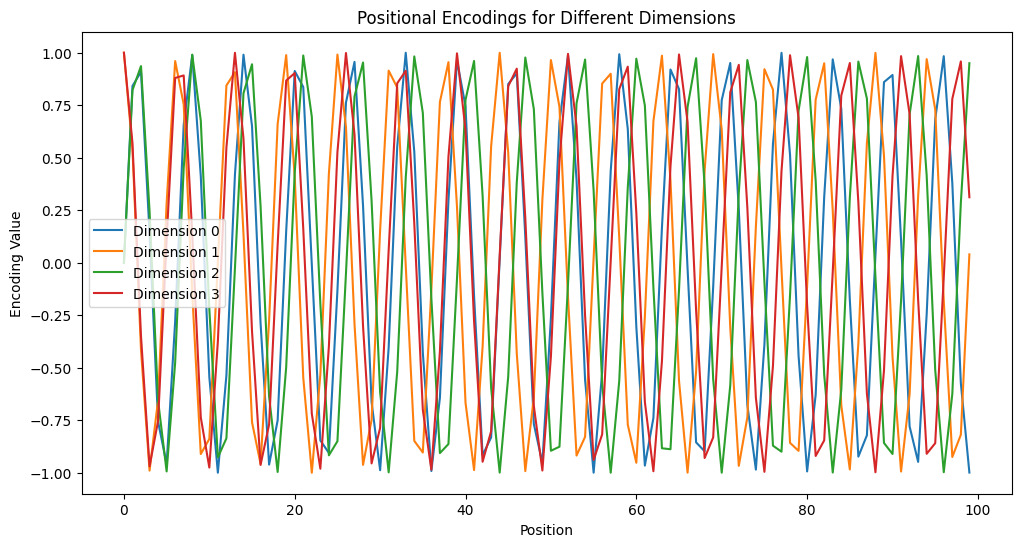

In [1]:
import torch
import math
import matplotlib.pyplot as plt

def positional_encoding(position, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(100.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Plot for positions 0-99 and dimensions 0, 1, 2, 3
positions = torch.arange(100).float()
d_model = 512

plt.figure(figsize=(12, 6))
pe = positional_encoding(positions, d_model)
for i in range(4):
    plt.plot(positions.numpy(), pe[:, i].numpy(), label=f'Dimension {i}')

plt.legend()
plt.title("Positional Encodings for Different Dimensions")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.show()

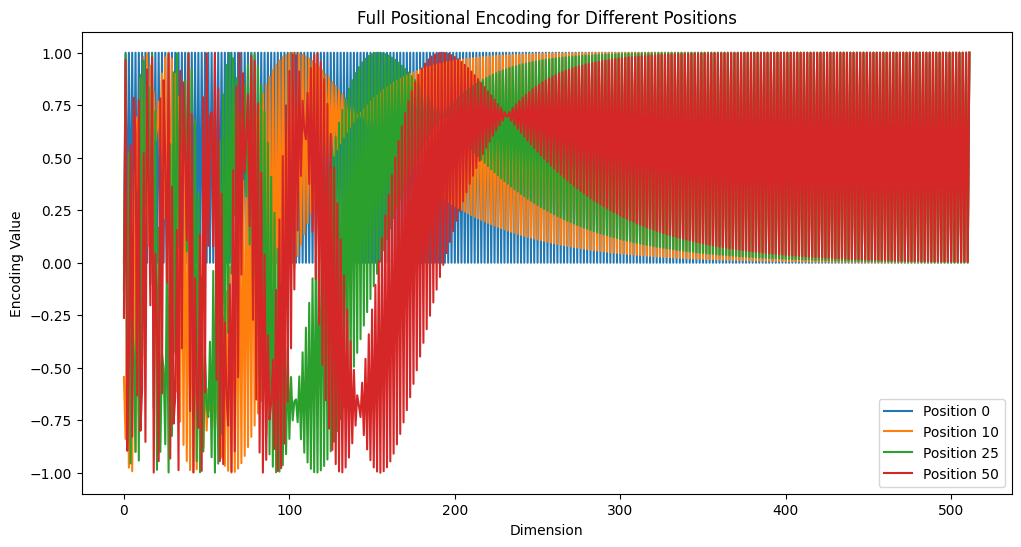

In [4]:
plt.figure(figsize=(12, 6))
for pos in [0, 10, 25, 50]:
    plt.plot(pe[pos].numpy(), label=f'Position {pos}')

plt.legend()
plt.title("Full Positional Encoding for Different Positions")
plt.xlabel("Dimension")
plt.ylabel("Encoding Value")
plt.show()

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(100.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

## Putting It All Together: A Simple Transformer Implementation

The provided code demonstrates how the key components we've discussed - positional encoding, layer normalization, and self-attention layers - come together to form a basic transformer model. Let's break down the `TransformerModel` class:

1. **Initialization (`__init__`)**:
   - `self.embed`: An embedding layer that converts input tokens to dense vectors.
   - `self.pos_encoder`: Adds positional information to the embedded tokens.
   - `self.layers`: A list of `SelfAttentionLayer` modules, forming the core of the transformer.
   - `self.norm`: A final layer normalization applied after all attention layers.
   - `self.decoder`: A linear layer that projects the final representations to vocabulary-sized logits.

2. **Forward Pass (`forward`)**:
   - Creates an attention mask to ensure the model only attends to previous tokens (for causal/autoregressive modeling).
   - Embeds the input tokens and adds positional encodings.
   - Passes the embeddings through each self-attention layer sequentially.
   - Applies a final layer normalization.
   - Projects the output to vocabulary-sized logits using the decoder.

This implementation showcases how:
- Positional encodings are added to token embeddings at the start.
- Multiple self-attention layers are stacked to process the input deeply.
- Layer normalization is applied both within the attention layers (not shown here, but typically part of `SelfAttentionLayer`) and at the end of the entire stack.
- The model maintains the same dimensionality (`embed_dim`) throughout, using residual connections (likely within `SelfAttentionLayer`) to facilitate gradient flow.

This structure allows the transformer to effectively process sequential data while maintaining awareness of token positions and leveraging the power of self-attention mechanisms.

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.layers = nn.ModuleList([SelfAttentionLayer(embed_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, src):
        mask = torch.triu(torch.ones(
            src.size(1), src.size(1), dtype=torch.bool, device=src.device)).T
        src = self.embed(src)
        src = self.pos_encoder(src)
        for layer in self.layers:
            src = layer(src, mask)
        src = self.norm(src)
        output = self.decoder(src)
        return output
